In [ ]:
import torch
import matplotlib.style
import matplotlib as mpl

mpl.style.use("default")

DEVICE = torch.device("cuda")
SEED = 76436278

checkpoint = torch.load('./model.pt')
torch.manual_seed(SEED)

In [ ]:
from maldi2resistance.data.driams import Driams

driams = Driams(
    root_dir="/home/jan/Uni/master/data/Driams",
    # antibiotics= ['Ciprofloxacin', 'Ceftriaxone', "Cefepime", "Piperacillin-Tazobactam", "Tobramycin"]
)

driams.loading_type = "memory"

train_size = int(0.8 * len(driams))
test_size = len(driams) - train_size

gen = torch.Generator()

train_dataset, test_dataset = torch.utils.data.random_split(driams, [train_size, test_size], generator= gen.manual_seed(SEED))

driams

Loading Spectra into Memory:   0%|          | 0/55780 [00:00<?, ?it/s]

Antibiotic:,Amikacin,Amoxicillin-Clavulanic acid,Ampicillin,Ampicillin-Amoxicillin,Aztreonam,Benzylpenicillin,Cefazolin,Cefepime,Cefpodoxime,Ceftazidime,Ceftriaxone,Cefuroxime,Ciprofloxacin,Clarithromycin,Clindamycin,Colistin,Cotrimoxazole,Ertapenem,Erythromycin,Fosfomycin,Fosfomycin-Trometamol,Fusidic acid,Gentamicin,Imipenem,Levofloxacin,Meropenem,Mupirocin,Nitrofurantoin,Norfloxacin,Oxacillin,Penicillin,Piperacillin-Tazobactam,Polymyxin B,Rifampicin,Teicoplanin,Tetracycline,Tobramycin,Vancomycin
Number resistant:,1068,13366,8578,21966,628,618,4223,7383,2338,3470,8659,5855,9338,310,4381,2874,7405,427,5468,2303,1326,3620,3481,7560,4217,5194,570,1271,1205,5537,12431,7616,486,580,244,3534,1707,227
Number susceptible:,20941,24992,4194,4905,456,457,5813,31567,4382,24566,28464,8368,36822,1262,9841,15784,24590,21740,9044,10184,4803,8498,22662,31717,17989,27228,4656,3603,7031,7740,4286,31308,2305,14964,8486,10376,16809,20540
Number data points:,22009,38358,12772,26871,1084,1075,10036,38950,6720,28036,37123,14223,46160,1572,14222,18658,31995,22167,14512,12487,6129,12118,26143,39277,22206,32422,5226,4874,8236,13277,16717,38924,2791,15544,8730,13910,18516,20767


In [ ]:
driams.label_stats

,Amikacin,Amoxicillin-Clavulanic acid,Ampicillin,Ampicillin-Amoxicillin,Aztreonam,Benzylpenicillin,Cefazolin,Cefepime,Cefpodoxime,Ceftazidime,...,Norfloxacin,Oxacillin,Penicillin,Piperacillin-Tazobactam,Polymyxin B,Rifampicin,Teicoplanin,Tetracycline,Tobramycin,Vancomycin
positive,1068,13366,8578,21966,628,618,4223,7383,2338,3470,...,1205,5537,12431,7616,486,580,244,3534,1707,227
negative,20941,24992,4194,4905,456,457,5813,31567,4382,24566,...,7031,7740,4286,31308,2305,14964,8486,10376,16809,20540
n_sum,22009,38358,12772,26871,1084,1075,10036,38950,6720,28036,...,8236,13277,16717,38924,2791,15544,8730,13910,18516,20767


In [ ]:
len(driams.selected_antibiotics)

38

In [ ]:
from torch.utils.data import DataLoader

test_loader = DataLoader(test_dataset, batch_size=test_size, shuffle=True)
test_features, test_labels = next(iter(test_loader))

In [ ]:
from torch import nn
from multimodal_amr.models.modules import ResMLP


class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.first = nn.Linear(18000 ,1024)
        self.res_mlp = ResMLP(
            n_layers= 5,
            dim= 1024,
            output_dim= len(driams.selected_antibiotics),
            p_dropout=0.2,
        )
        
    def forward(self, x):

        h_ = self.first(x)
        h_ = self.res_mlp(h_)
        
        output = torch.sigmoid(h_)

        return output


In [ ]:
model = Model()

model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
model.to(DEVICE)

Model(
  (first): Linear(in_features=18000, out_features=1024, bias=True)
  (res_mlp): ResMLP(
    (net): Sequential(
      (0): ResBlock(
        (block): Sequential(
          (0): ReLU()
          (1): Linear(in_features=1024, out_features=1024, bias=True)
          (2): Dropout(p=0.2, inplace=False)
          (3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (1): ResBlock(
        (block): Sequential(
          (0): ReLU()
          (1): Linear(in_features=1024, out_features=1024, bias=True)
          (2): Dropout(p=0.2, inplace=False)
          (3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): ResBlock(
        (block): Sequential(
          (0): ReLU()
          (1): Linear(in_features=1024, out_features=1024, bias=True)
          (2): Dropout(p=0.2, inplace=False)
          (3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [ ]:
model = model.to(DEVICE)

test_features = test_features.view(test_size, 18000)
test_features = test_features.to(DEVICE)

test_labels = test_labels.view(test_size, len(driams.selected_antibiotics))
test_labels = test_labels.to(DEVICE)

In [ ]:
output = model(test_features)

In [ ]:
len(driams.selected_antibiotics)

38

In [ ]:
output.shape

torch.Size([11156, 38])

(0.9093402624130249, 0.8883729969200335)


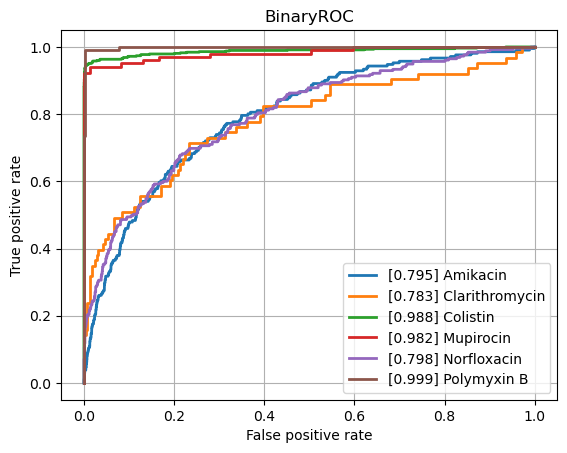

In [ ]:
from maldi2resistance.metric.ROC import MultiLabelRocNan
import matplotlib.pyplot as plt

ml_roc = MultiLabelRocNan()
print(ml_roc.compute(output,test_labels,driams.selected_antibiotics, create_csv="./ROC_results.csv"))
fig_, ax_ = ml_roc()

plt.savefig("./ROC_results.png" , transparent=True, format= "png", bbox_inches = "tight")
plt.show()

(0.8357232809066772, 0.7305817062917509)


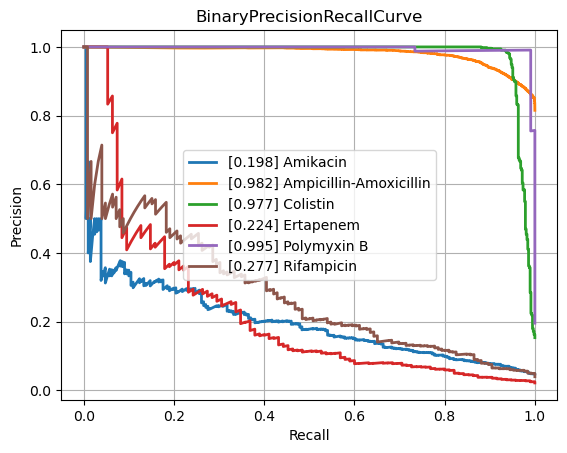

In [ ]:
from maldi2resistance.metric.PrecisionRecall import MultiLabelPRNan
import matplotlib.pyplot as plt

ml_pr = MultiLabelPRNan()
print(ml_pr.compute(output,test_labels,driams.selected_antibiotics, create_csv="./PR_results.csv"))

fig_, ax_ = ml_pr()

plt.savefig("./PR_results.png" , transparent=True, format= "png", bbox_inches = "tight")
plt.show()

In [ ]:
test_features.shape

torch.Size([11156, 18000])

In [ ]:
#test_features= test_features[1:,:]
#test_labels= test_labels[1:,:]

In [ ]:
split1,split2 = torch.chunk(test_features, 2)
combined =torch.add(split1 , split2)
combined_features = torch.div(combined, 2)

In [ ]:
split1,split2 = torch.chunk(test_labels, 2)
combined =torch.add(split1 , split2)
combined_labels = torch.div(combined, 2)
combined_labels[combined_labels == 0.5] =1

In [ ]:
output = model(combined_features)

/home/jan/anaconda3/envs/master_backend/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


(0.7797096967697144, 0.7535024771564885)


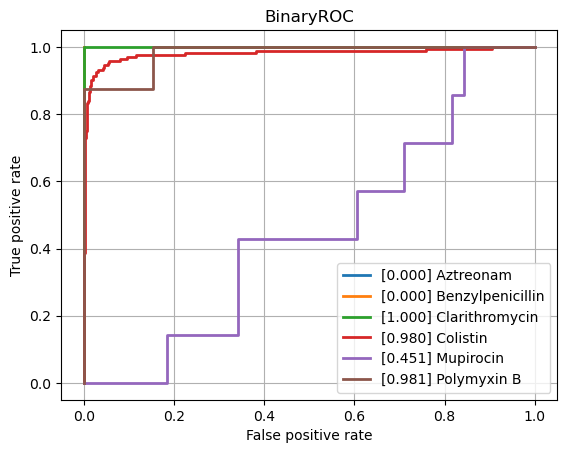

In [ ]:
from maldi2resistance.metric.ROC import MultiLabelRocNan
import matplotlib.pyplot as plt

ml_roc = MultiLabelRocNan()
print(ml_roc.compute(output,combined_labels,driams.selected_antibiotics, create_csv="./ROC_combined_results.csv"))
fig_, ax_ = ml_roc()

plt.savefig("./ROC_combined_results.png" , transparent=True, format= "png", bbox_inches = "tight")
plt.show()

(0.7550061941146851, 0.7030196013419252)


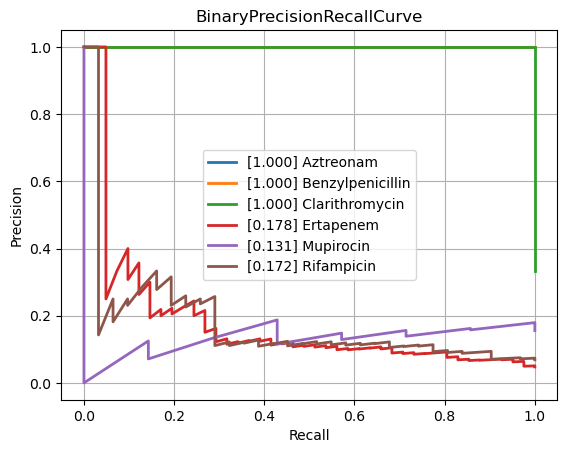

In [ ]:
from maldi2resistance.metric.PrecisionRecall import MultiLabelPRNan
import matplotlib.pyplot as plt

ml_pr = MultiLabelPRNan()
print(ml_pr.compute(output,combined_labels,driams.selected_antibiotics, create_csv="./PR_combined_results.csv"))

fig_, ax_ = ml_pr()

plt.savefig("./PR_combined_results.png" , transparent=True, format= "png", bbox_inches = "tight")
plt.show()

In [ ]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

mpl.style.use("default")

result = pd.read_csv('./results.csv')
mix_result = pd.read_csv('./combined_results.csv')

combined = pd.merge(result, mix_result, on='class', how='outer', suffixes=('', '_mix'))
combined.set_index("class", inplace=True)
combined

,PrecisionRecallAUC,FrequencyPositiveClass,PrecisionRecallAUC_mix,FrequencyPositiveClass_mix
class,,,,
Amikacin,0.157772,0.030607,0.184036,0.064220
Amoxicillin-Clavulanic acid,0.839839,0.306234,0.844864,0.507947
Ampicillin,0.933962,0.655389,0.979549,0.894558
Ampicillin-Amoxicillin,0.978944,0.794595,0.996834,0.954315
Benzylpenicillin,0.935714,0.515556,0.968502,0.888889
Cefazolin,0.868720,0.361360,0.922010,0.666667
Cefepime,0.645997,0.122859,0.491897,0.227124
Cefpodoxime,0.903564,0.362025,0.964850,0.833333
Ceftazidime,0.368294,0.100032,0.362421,0.185012
